In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement
import sys

sys.path.append("..")
from data.utils import *
from data.load_raw_data import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


In [4]:
points_main, leaves, semantics = load_real_ply_with_labels("/space/ariyanzarei/sorghum_segmentation/dataset/real_data/labeled/ply_files/BTx_623_3001_330755982981.ply")
pcd = create_ply_pcd_from_points_with_labels(points_main,leaves,False)
# o3d.visualization.draw_geometries([pcd])

In [5]:
points = points_main[semantics==1]

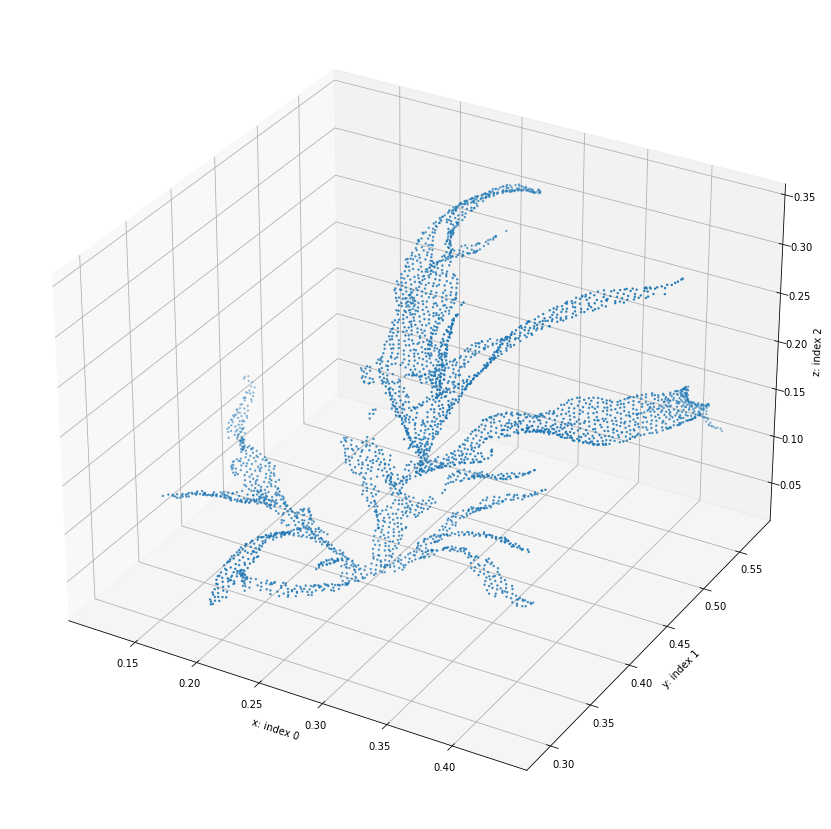

In [6]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], s=2)
ax.set_xlabel("x: index 0")
ax.set_ylabel("y: index 1")
ax.set_zlabel("z: index 2")
plt.show()